In [20]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE


from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

import matplotlib.pyplot as plt
import cv2

from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests


In [21]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from transformers import YolosFeatureExtractor, YolosForObjectDetection

# Assuming you have these functions available
# from your_module import get_training_data_path, remove_shadow_rgb

# Load the pre-trained model and feature extractor
# model_name = "valentinafeve/yolos-fashionpedia"
# feature_extractor = YolosFeatureExtractor.from_pretrained(model_name)
# model = YolosForObjectDetection.from_pretrained(model_name)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained('hustvl/yolos-tiny')


Detected umbrella with confidence 0.696 at location [244.36, 57.82, 685.18, 446.06]
Detected tie with confidence 0.608 at location [357.9, 88.73, 392.07, 120.06]


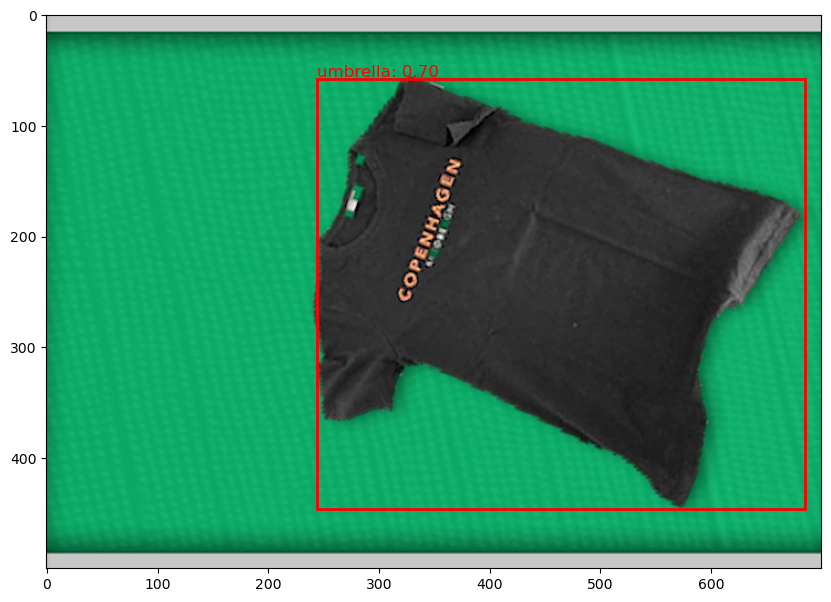

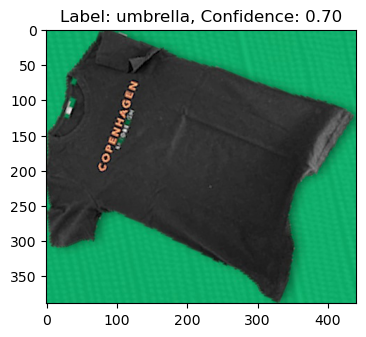

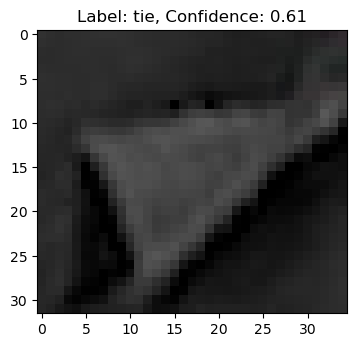

In [32]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Assuming these functions and variables are defined elsewhere in your code
# image_processor = ...
# model = ...

# Load and preprocess the image
relative_path = get_training_data_path('production', 'band')
fullpath = os.path.join(relative_path, 'frame_orig_30.jpg')
image = Image.open(fullpath)
image = image.rotate(0)

w, h = image.size
x = w / 2

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

# Define your target_sizes and outputs
target_sizes = torch.tensor([image.size[::-1]])
# Assuming outputs contain predictions from your model
# Adjust threshold according to your requirement
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

# Print detected objects and confidence scores
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.detach().numpy().tolist()]  # Detach tensor and convert to numpy array
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

# Plot image with bounding boxes
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(image)

for box, score, label in zip(results['boxes'], results['scores'], results['labels']):
    box = box.detach().numpy()  # Detach tensor and convert to numpy array
    x_min, y_min, x_max, y_max = box
    box_width = x_max - x_min
    box_height = y_max - y_min

    # Create a rectangle patch
    rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

    # Add label and confidence score
    ax.text(x_min, y_min - 2, f'{model.config.id2label[label.item()]}: {score.item():0.2f}', fontsize=12, color='red')

    # Convert image to numpy array
    img_array = np.array(image)

    # Ensure the coordinates are within the image dimensions
    x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
    cropped_image = img_array[y_min:y_max, x_min:x_max]
    cv2.imwrite(f"./scoreest.jpg", cropped_image)
    # Display the cropped image
    fig, ax_cropped = plt.subplots(1, figsize=(4, 4))  # Use reasonable size for the cropped image
    ax_cropped.imshow(cropped_image)
    ax_cropped.set_title(f'Label: {model.config.id2label[label.item()]}, Confidence: {score.item():0.2f}')
    plt.show()

# Show the final image with all bounding boxes
#plt.show()


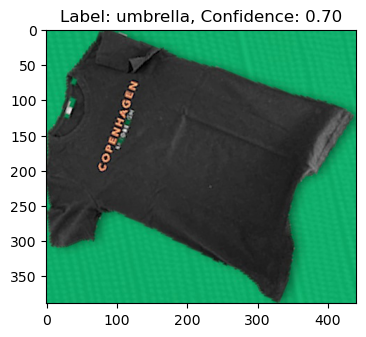

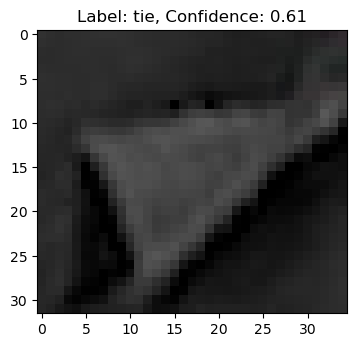

In [35]:
def process(image):
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    logits = outputs.logits
    bboxes = outputs.pred_boxes

    image  = np.array(image)  # Convert the image to a NumPy array once
    height, width, _ = image.shape
    target_sizes = torch.tensor([[height, width]])  # Note the double square brackets

    plt.show()

    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

    # Print detected objects and confidence scores
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.detach().numpy().tolist()]  # Detach tensor and convert to numpy array

    detected = False
    detected_cropped_image = None


    for box, score, label in zip(results['boxes'], results['scores'], results['labels']):
        box = box.detach().numpy()  # Detach tensor and convert to numpy array
        x_min, y_min, x_max, y_max = box
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Ensure the coordinates are within the image dimensions
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        cropped_image = image[y_min:y_max, x_min:x_max]
        fig, ax_cropped = plt.subplots(1, figsize=(4, 4))  # Use reasonable size for the cropped image
        ax_cropped.imshow(cropped_image)
        ax_cropped.set_title(f'Label: {model.config.id2label[label.item()]}, Confidence: {score.item():0.2f}')
        plt.show()


process(image)